In [ ]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/Mask_Data'

folders = os.listdir(data_dir)

for folder in folders:
    print(f"Le dossier {folder} contient {len(os.listdir(os.path.join(data_dir, folder)))} images")


Le dossier with_mask contient 755 images
Le dossier without_mask contient 753 images


In [ ]:
# Définition des paramètres
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.20
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1207 images belonging to 2 classes.
Found 301 images belonging to 2 classes.


In [ ]:
# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajout de la couche de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Définition de ModelCheckpoint pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 281s 7s/step - loss: 0.2492 - accuracy: 0.8625 - val_loss: 0.0666 - val_accuracy: 0.9701
Epoch 2/10
38/38 [==============================] - 32s 832ms/step - loss: 0.0469 - accuracy: 0.9851 - val_loss: 0.0179 - val_accuracy: 0.9967
Epoch 3/10
38/38 [==============================] - 30s 776ms/step - loss: 0.0345 - accuracy: 0.9901 - val_loss: 0.0186 - val_accuracy: 0.9900
Epoch 4/10
38/38 [==============================] - 29s 775ms/step - loss: 0.0187 - accuracy: 0.9950 - val_loss: 0.0147 - val_accuracy: 0.9967
Epoch 5/10
38/38 [==============================] - 30s 785ms/step - loss: 0.0326 - accuracy: 0.9884 - val_loss: 0.0136 - val_accuracy: 0.9900
Epoch 6/10
38/38 [==============================] - 30s 775ms/step - loss: 0.0308 - accuracy: 0.9859 - val_loss: 0.0186 - val_accuracy: 0.9967
Epoch 7/10
38/38 [==============================] - 30s 788ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 8/10
3

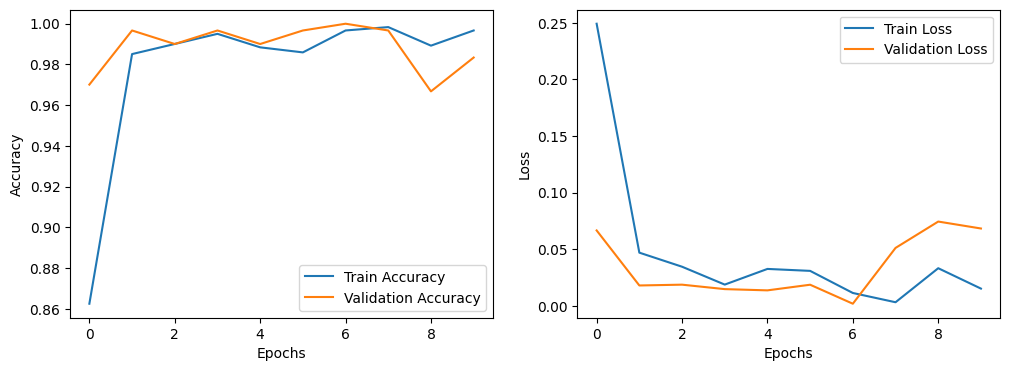

In [ ]:
# Tracé des courbes d'accuracy et de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Évaluation du modèle sur les données de test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Found 1508 images belonging to 2 classes.
48/48 [==============================] - 9s 186ms/step - loss: 9.9119e-04 - accuracy: 0.9993
Test Accuracy: 0.9993368983268738


In [ ]:
# Matrice de confusion et rapport de classification
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Matrice de Confusion :")
print(confusion_matrix(test_generator.classes, y_pred))
print("Rapport de Classification :")
target_names = ['Avec_Masque', 'Sans_Masque']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 9s 176ms/step
Matrice de Confusion :
[[380 375]
 [374 379]]
Rapport de Classification :
              precision    recall  f1-score   support

 Avec_Masque       0.50      0.50      0.50       755
 Sans_Masque       0.50      0.50      0.50       753

    accuracy                           0.50      1508
   macro avg       0.50      0.50      0.50      1508
weighted avg       0.50      0.50      0.50      1508



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


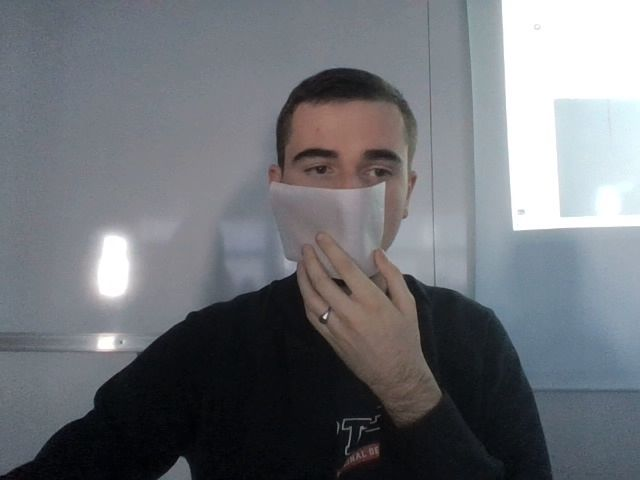

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Charger le modèle pré-entraîné
model = load_model("best_model.h5")

# Chargement de l'image
image = cv2.imread("photo.jpg")

# Redimensionner l'image à la taille attendue par le modèle (224x224 pixels)
image = cv2.resize(image, (224, 224))

# Reshape l'image pour qu'elle ait la forme attendue par le modèle (1, 224, 224, 3)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prédire la classe de l'image
predictions = model.predict(image)

# L'étiquette de classe prédite correspond à la classe avec la probabilité la plus élevée
predicted_class = np.argmax(predictions)

# Définir le message de prédiction
if predicted_class == 0:
    message = "Avec masque"
else:
    message = "Non masque"

# Afficher l'image avec le message
plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
plt.title(message)
plt.axis('off')  # Masquer les axes
plt.show()
